# XOR With BNN

one of the thing you can make as a newbie with NN is a MNIST clasification. This file is praticly the same as the [Introduction to BNNs with Larq](https://docs.larq.dev/larq/tutorials/mnist/) with extra comment and gpu

## Setting up the environement

The LARQ library only compatitble with a certain version of tensorflow, hence also the cuda, so do keep in mind

In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import larq as lq
print("Larq version:", lq.__version__)

import time


2025-04-06 01:00:12.642971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-06 01:00:12.934972: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-06 01:00:14.254779: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zaim22/anaconda3/envs/larq-env/lib:/opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/lib/x86_64-linux-gnu:/opt/ros/humble/lib:/usr/local/cuda-12.8/lib64:
2025-04-06 01:00:14.254948: W tensorflow/stre

TensorFlow version: 2.10.0
Larq version: 0.13.3


### Check for CUDA

In [6]:
print("Is CUDA available:", tf.test.is_built_with_cuda())
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

Is CUDA available: True
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Getting the data

In [7]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# Normalize pixel values to be between -1 and 1
train_images, test_images = train_images / 127.5 - 1, test_images / 127.5 - 1

11490434/11490434 [==============================] - 4s 0us/step


## Model initialization

In [35]:
# All quantized layers except the first will use the same options
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip")

model = tf.keras.models.Sequential()

# In the first layer we only quantize the weights and not the input
model.add(lq.layers.QuantConv2D(32, (3, 3),
                                kernel_quantizer="ste_sign",
                                kernel_constraint="weight_clip",
                                use_bias=False,
                                input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(scale=False))

model.add(lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(scale=False))

model.add(lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Flatten())

model.add(lq.layers.QuantDense(64, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Activation("softmax"))

In [9]:
lq.models.summary(model)

+sequential stats------------------------------------------------------------------------------------------+
| Layer                  Input prec.           Outputs  # 1-bit  # 32-bit  Memory  1-bit MACs  32-bit MACs |
|                              (bit)                        x 1       x 1    (kB)                          |
+----------------------------------------------------------------------------------------------------------+
| quant_conv2d                     -  (-1, 26, 26, 32)      288         0    0.04           0       194688 |
| max_pooling2d                    -  (-1, 13, 13, 32)        0         0       0           0            0 |
| batch_normalization              -  (-1, 13, 13, 32)        0        64    0.25           0            0 |
| quant_conv2d_1                   1  (-1, 11, 11, 64)    18432         0    2.25     2230272            0 |
| max_pooling2d_1                  -    (-1, 5, 5, 64)        0         0       0           0            0 |
| batch_normalizati

## Training

In [34]:
with tf.device('/GPU:0'):  # Use '/GPU:0' for the first GPU or '/CPU:0' for CPU
    # Compile the model (this will also use the GPU if available)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Start timing
    start_time = time.time()
    
    # Train the model
    model.fit(train_images, train_labels, batch_size=64, epochs=10)
    
    # End timing
    end_time = time.time()
    print('Total Training Time: %.2f min' % ((end_time - start_time) / 60))

# Evaluate the model (this will also use the GPU if available)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc}")

Epoch 1/10
938/938 [==============================] - 7s 6ms/step - loss: 0.4123 - accuracy: 0.9835
Epoch 2/10
938/938 [==============================] - 7s 7ms/step - loss: 0.4120 - accuracy: 0.9837
Epoch 3/10
938/938 [==============================] - 6s 7ms/step - loss: 0.4089 - accuracy: 0.9842
Epoch 4/10
938/938 [==============================] - 6s 7ms/step - loss: 0.4109 - accuracy: 0.9830
Epoch 5/10
938/938 [==============================] - 6s 7ms/step - loss: 0.4113 - accuracy: 0.9830
Epoch 6/10
938/938 [==============================] - 6s 6ms/step - loss: 0.4093 - accuracy: 0.9836
Epoch 7/10
938/938 [==============================] - 6s 6ms/step - loss: 0.4090 - accuracy: 0.9839
Epoch 8/10
938/938 [==============================] - 6s 6ms/step - loss: 0.4101 - accuracy: 0.9830
Epoch 9/10
938/938 [==============================] - 6s 6ms/step - loss: 0.4087 - accuracy: 0.9839
Epoch 10/10
938/938 [==============================] - 6s 7ms/step - loss: 0.4116 - accuracy: 0.9836

1/1 [==============================] - 0s 49ms/step


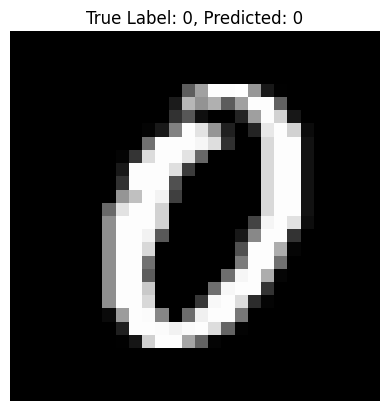

In [26]:
import numpy as np

import matplotlib.pyplot as plt

# Select a random test image
index = np.random.randint(0, len(test_images))
image = test_images[index]
true_label = test_labels[index]

# Predict the label
predictions = model.predict(image[np.newaxis, ...])
predicted_label = np.argmax(predictions)

# Display the image and prediction
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"True Label: {true_label}, Predicted: {predicted_label}")
plt.axis('off')
plt.show()